In [ ]:
! python --version

### Import libs

In [1]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import word2vec
import multiprocessing
import sklearn

import pandas as pd
import random
import numpy as np
import unicodedata
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import logging

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.model_selection import StratifiedShuffleSplit
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
print(gensim.__version__)

3.8.0


### Functions to Clean Text

In [3]:
stop_words = stopwords.words('portuguese')
stop_words.pop(stop_words.index('não'))
new_stopwords = ('bom', 'dia', 'ola', 'eu')
for i in new_stopwords:
    stop_words.append(i)

def anonymizer(text,stop_words):
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode('utf-8')
    text = re.sub(' +', ' ', str(text).lower())
    text = re.sub('((http?|ftp|smtp):\/\/)?(www.)?[a-z0-9]+\.[a-z]+(\/[a-zA-Z0-9#]+\/?)*', ' ', str(text).lower())
    text = re.sub('\S+@\S+', ' ', str(text).lower())
    text = re.sub('@\S+', ' ', str(text).lower())
    text = re.sub('\d', ' ', str(text).lower())
    text = re.sub('https:\S+', ' ', str(text).lower())
    text = re.sub('[^a-z0-9 ]+', ' ', str(text).lower())
    text = nltk.tokenize.word_tokenize(text, language='portuguese')
    return ' '.join([w for w in text if not w in stop_words])

### Analise de score do texto

### Converter as frases em um dataset pandas

In [4]:
dados = {'indices_id': ['0','1','2','3'],
         'Frase original': ['Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?',
                           'Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?',
                           'Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?',
                           'Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?'],
         'Frases comparativas': ['De acordo com a escala de dor ali na parede', 
                                'qual valor você acha que mais representa a sua dor?',
                                'De 0 a 10, qual o nível de intensidade da sua dor atualmente?',
                                'Qual a intensidade da sua dor?'],
         }

In [5]:
dataset = pd.DataFrame(dados)

In [6]:
dataset

,indices_id,Frase original,Frases comparativas
0,0,"Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?",De acordo com a escala de dor ali na parede
1,1,"Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?",qual valor você acha que mais representa a sua dor?
2,2,"Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?","De 0 a 10, qual o nível de intensidade da sua dor atualmente?"
3,3,"Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?",Qual a intensidade da sua dor?


In [7]:
dataset.shape

(4, 3)

In [8]:
dataset['frase_original_clean'] = dataset['Frase original'].apply(lambda x: anonymizer(x, stop_words))
dataset['Frases_comparativas_clean'] = dataset['Frases comparativas'].apply(lambda x: anonymizer(x, stop_words))

### Comparative original column with column clean

In [9]:
dataset[['Frase original','frase_original_clean', 'Frases comparativas','Frases_comparativas_clean']]

,Frase original,frase_original_clean,Frases comparativas,Frases_comparativas_clean
0,"Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?",olhando escala parede valor indicaria melhor dor hoje,De acordo com a escala de dor ali na parede,acordo escala dor ali parede
1,"Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?",olhando escala parede valor indicaria melhor dor hoje,qual valor você acha que mais representa a sua dor?,valor voce acha representa dor
2,"Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?",olhando escala parede valor indicaria melhor dor hoje,"De 0 a 10, qual o nível de intensidade da sua dor atualmente?",nivel intensidade dor atualmente
3,"Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?",olhando escala parede valor indicaria melhor dor hoje,Qual a intensidade da sua dor?,intensidade dor


### Creating tokens and training model Word2Vec

In [10]:
def build_corpus(data):
    corpus = []
    for sentence in data:
        word_list = sentence.split(" ")
        corpus.append(word_list)
    return corpus

def createModel_word2vec(text,size=None,min_count=None,window=None):
    model = gensim.models.word2vec.Word2Vec(text,min_count=min_count,window=window,workers=10)
    return model

In [11]:
dataset["Frases_comparativas_clean_wc"] = build_corpus(dataset['Frases_comparativas_clean'])
dataset["frase_original_clean_wc"] = build_corpus(dataset['frase_original_clean'])

In [12]:
dataset[['frase_original_clean_wc',"Frases_comparativas_clean_wc"]]

,frase_original_clean_wc,Frases_comparativas_clean_wc
0,"[olhando, escala, parede, valor, indicaria, melhor, dor, hoje]","[acordo, escala, dor, ali, parede]"
1,"[olhando, escala, parede, valor, indicaria, melhor, dor, hoje]","[valor, voce, acha, representa, dor]"
2,"[olhando, escala, parede, valor, indicaria, melhor, dor, hoje]","[nivel, intensidade, dor, atualmente]"
3,"[olhando, escala, parede, valor, indicaria, melhor, dor, hoje]","[intensidade, dor]"


### Concat columns and convert all words in vector

In [13]:
dataset["concat"] = dataset["frase_original_clean_wc"] + dataset["Frases_comparativas_clean_wc"]

In [14]:
dataset['concat']

0       [olhando, escala, parede, valor, indicaria, melhor, dor, hoje, acordo, escala, dor, ali, parede]
1     [olhando, escala, parede, valor, indicaria, melhor, dor, hoje, valor, voce, acha, representa, dor]
2    [olhando, escala, parede, valor, indicaria, melhor, dor, hoje, nivel, intensidade, dor, atualmente]
3                       [olhando, escala, parede, valor, indicaria, melhor, dor, hoje, intensidade, dor]
Name: concat, dtype: object

### Training model

In [15]:
model_wc = createModel_word2vec(dataset['concat'],min_count=1,window=10)

In [16]:
type(model_wc)

gensim.models.word2vec.Word2Vec

### Visualize Vocabulary

In [17]:
model_wc.wv.vocab

{'olhando': <gensim.models.keyedvectors.Vocab at 0x7f5658521d90>,
 'escala': <gensim.models.keyedvectors.Vocab at 0x7f5658521970>,
 'parede': <gensim.models.keyedvectors.Vocab at 0x7f5658521d00>,
 'valor': <gensim.models.keyedvectors.Vocab at 0x7f5658521490>,
 'indicaria': <gensim.models.keyedvectors.Vocab at 0x7f5658521520>,
 'melhor': <gensim.models.keyedvectors.Vocab at 0x7f5658521b80>,
 'dor': <gensim.models.keyedvectors.Vocab at 0x7f5658521dc0>,
 'hoje': <gensim.models.keyedvectors.Vocab at 0x7f56585214c0>,
 'acordo': <gensim.models.keyedvectors.Vocab at 0x7f5658521d60>,
 'ali': <gensim.models.keyedvectors.Vocab at 0x7f565858bf10>,
 'voce': <gensim.models.keyedvectors.Vocab at 0x7f565858b610>,
 'acha': <gensim.models.keyedvectors.Vocab at 0x7f55ecfc9a90>,
 'representa': <gensim.models.keyedvectors.Vocab at 0x7f5658587ca0>,
 'nivel': <gensim.models.keyedvectors.Vocab at 0x7f5658521e20>,
 'intensidade': <gensim.models.keyedvectors.Vocab at 0x7f55eccb9cd0>,
 'atualmente': <gensim.mod

In [18]:
[x for x in model_wc.wv.vocab]

['olhando',
 'escala',
 'parede',
 'valor',
 'indicaria',
 'melhor',
 'dor',
 'hoje',
 'acordo',
 'ali',
 'voce',
 'acha',
 'representa',
 'nivel',
 'intensidade',
 'atualmente']

### Get similar words

In [19]:
[(item[0],round(item[1],2)) for item in model_wc.most_similar('dor')]

<ipython-input-19-caf29175ad26>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  [(item[0],round(item[1],2)) for item in model_wc.most_similar('dor')]


[('representa', 0.26),
 ('acordo', 0.11),
 ('intensidade', 0.1),
 ('escala', 0.06),
 ('atualmente', 0.04),
 ('ali', 0.03),
 ('voce', 0.02),
 ('parede', -0.01),
 ('olhando', -0.01),
 ('melhor', -0.03)]

In [20]:
keys = [x for x in model_wc.wv.vocab]
embedding_clusters = []
word_clusters = []
for word in keys:
    print(word)
    embeddings = []
    words = []
    for similar_word, _ in model_wc.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(model_wc[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)
    
    model_wc.most_similar

olhando
escala
parede
valor
indicaria
melhor
dor
hoje
acordo
ali
voce
acha
representa
nivel
intensidade
atualmente


<ipython-input-20-d76d8bbdbf23>:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  for similar_word, _ in model_wc.most_similar(word, topn=30):
<ipython-input-20-d76d8bbdbf23>:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embeddings.append(model_wc[similar_word])


### Word Embedding

In [21]:
from sklearn.manifold import TSNE
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=10, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f55eccd2430>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


### Plot with similar words

In [22]:
import matplotlib.cm as cm

def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

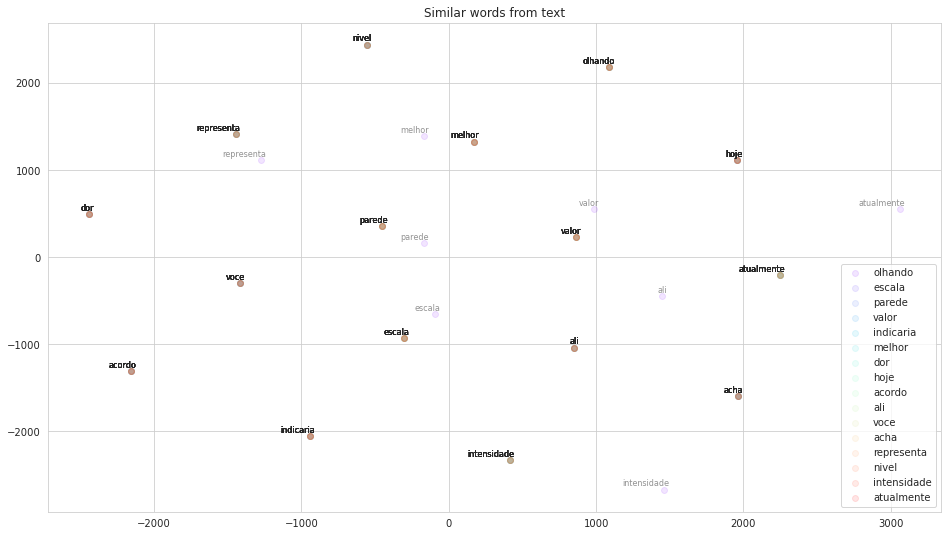

In [23]:
tsne_plot_similar_words('Similar words from text', keys, embeddings_en_2d, word_clusters, 0.1,
                        'similar_words.png')

In [24]:
w2v_vocab = set(model_wc.wv.vocab)
print("Loaded {} words in vocabulary".format(len(w2v_vocab)))

Loaded 16 words in vocabulary


### Make a similarity matrix for words and visualise

In [25]:
words = [x for x in model_wc.wv.vocab]
similarities = np.zeros((len(words), len(words)), dtype=np.float_)
for idx1, word1 in enumerate(words):
    for idx2, word2 in enumerate(words):
        # note KeyError is possible if word doesn't exist
        sim = model_wc.similarity(word1, word2)
        similarities[idx1, idx2] = sim
        
df = pd.DataFrame.from_records(similarities, columns=words)
df.index = words

<ipython-input-25-c1eab9ff789f>:6: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  sim = model_wc.similarity(word1, word2)


In [26]:
df

,olhando,escala,parede,valor,indicaria,melhor,dor,hoje,acordo,ali,voce,acha,representa,nivel,intensidade,atualmente
olhando,1.000000,0.066520,0.059545,0.059261,0.040879,0.092491,-0.014007,-0.010815,-0.019669,0.259668,-0.032008,-0.068594,0.048166,0.004514,0.192427,0.081342
escala,0.066520,1.000000,-0.122987,-0.058753,-0.066437,0.090064,0.059045,0.001988,0.054723,0.137967,0.077290,0.044742,0.151934,-0.038407,-0.009756,0.089586
parede,0.059545,-0.122987,1.000000,-0.091892,0.062876,0.031719,-0.013811,0.051383,0.075287,-0.047179,-0.031599,-0.124243,0.154249,-0.039371,-0.055442,0.024099
valor,0.059261,-0.058753,-0.091892,1.000000,-0.043724,-0.084003,-0.131630,0.039856,-0.192903,0.137006,-0.097976,0.002215,-0.080036,0.081097,0.063629,0.228253
indicaria,0.040879,-0.066437,0.062876,-0.043724,1.000000,-0.052909,-0.058250,-0.003566,0.023978,-0.018399,0.084172,-0.020667,-0.076871,-0.073293,0.071192,0.079305
melhor,0.092491,0.090064,0.031719,-0.084003,-0.052909,1.000000,-0.026657,-0.071935,-0.116909,-0.036878,0.110572,-0.066008,0.018942,0.097200,-0.100968,-0.209461
dor,-0.014007,0.059045,-0.013811,-0.131630,-0.058250,-0.026657,1.000000,-0.187446,0.111317,0.031149,0.018289,-0.057319,0.256818,-0.093899,0.102251,0.038781
hoje,-0.010815,0.001988,0.051383,0.039856,-0.003566,-0.071935,-0.187446,1.000000,0.099098,0.075090,-0.078092,0.166276,0.022120,0.049556,0.004095,0.051051
acordo,-0.019669,0.054723,0.075287,-0.192903,0.023978,-0.116909,0.111317,0.099098,1.000000,0.060068,0.152804,0.027075,0.097163,-0.214558,0.051077,-0.049887
ali,0.259668,0.137967,-0.047179,0.137006,-0.018399,-0.036878,0.031149,0.075090,0.060068,1.000000,-0.094176,0.024752,0.195097,-0.115241,0.141723,0.103890


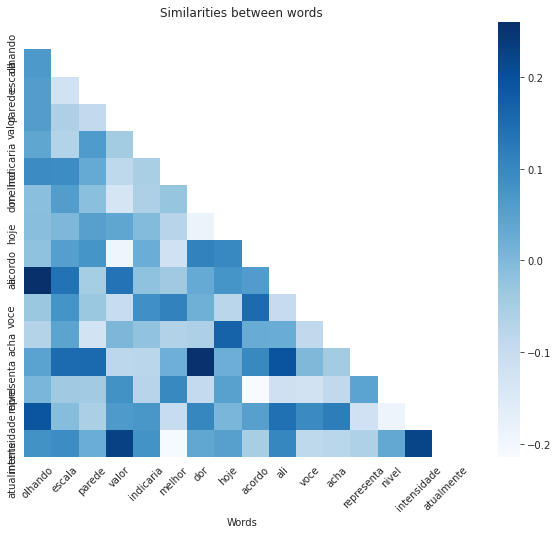

In [27]:
f, ax=plt.subplots(1, 1, figsize=(14,8))
cmap = plt.cm.Blues
mask = np.zeros_like(df)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df, cmap=cmap, mask=mask, square=True, ax=ax)
_=plt.yticks(rotation=90)
plt.xlabel('Words')
_=plt.xticks(rotation=45)
_=plt.title("Similarities between words")

### Score a target sentence to source sentences

In [28]:
#target_sentence = "You'd love to drink a cool refreshing Coke"
target_sentence = ["Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?",
                  "De acordo com a escala de dor ali na parede",
                  'qual valor você acha que mais representa a sua dor?',
                                'De 0 a 10, qual o nível de intensidade da sua dor atualmente?',
                                'Qual a intensidade da sua dor?']

In [29]:
# use n_similarity to compute a cosine similarity (should be reasonably robust)

for i in target_sentence:
    sentences = [x for x in model_wc.wv.vocab]
    sentences_similarity = np.zeros(len(sentences))

    target_sentence_words = [w for w in i.split() if w in w2v_vocab]
    for idx, sentence in enumerate(sentences):
        sentence_words = [w for w in sentence.split() if w in w2v_vocab]
        sim = model_wc.n_similarity(target_sentence_words, sentence_words)
        sentences_similarity[idx] = sim

    result = list(zip(sentences_similarity, sentences))
    result.sort(key=lambda item:item[0], reverse=True)
    print("Target:", target_sentence)
    print(result)

Target: ['Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?', 'De acordo com a escala de dor ali na parede', 'qual valor você acha que mais representa a sua dor?', 'De 0 a 10, qual o nível de intensidade da sua dor atualmente?', 'Qual a intensidade da sua dor?']
[(0.4966461658477783, 'escala'), (0.4406518042087555, 'dor'), (0.43866732716560364, 'melhor'), (0.367131769657135, 'indicaria'), (0.31794899702072144, 'valor'), (0.14009332656860352, 'representa'), (0.12149690836668015, 'ali'), (0.11629859358072281, 'olhando'), (0.10999873280525208, 'atualmente'), (0.09262657165527344, 'voce'), (0.06411342322826385, 'intensidade'), (-0.017160601913928986, 'nivel'), (-0.047951534390449524, 'acha'), (-0.05183010920882225, 'acordo'), (-0.06523484736680984, 'parede'), (-0.1124240830540657, 'hoje')]
Target: ['Olhando para a escala na parede, qual valor indicaria melhor a sua dor hoje?', 'De acordo com a escala de dor ali na parede', 'qual valor você acha que mais represent

<ipython-input-29-589428ef2963>:10: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  sim = model_wc.n_similarity(target_sentence_words, sentence_words)


### Test some word relationships

In [30]:
model_wc.most_similar(positive=["acordo", "melhor"], negative=['dor', 'intensidade'])

<ipython-input-30-60883f20d73e>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model_wc.most_similar(positive=["acordo", "melhor"], negative=['dor', 'intensidade'])


[('hoje', 0.10658234357833862),
 ('parede', 0.08923882991075516),
 ('nivel', 0.08392475545406342),
 ('voce', 0.07689313590526581),
 ('escala', 0.048350244760513306),
 ('representa', -0.011853128671646118),
 ('indicaria', -0.02120007574558258),
 ('acha', -0.05092678964138031),
 ('olhando', -0.05346353352069855),
 ('ali', -0.0757831335067749)]

### Project a set of words (via their 30 dimensional vector) using T-SNE

<ipython-input-31-da48ab1e3c05>:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  for word, _ in model_wc.most_similar(woi):
<ipython-input-31-da48ab1e3c05>:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vectors.append(model_wc[word])
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f55eca90040>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
 

Text(0.5, 1.0, "Word similarity (T-SNE) using vectors from 16 words\nColoured by similarity to 'dor'")

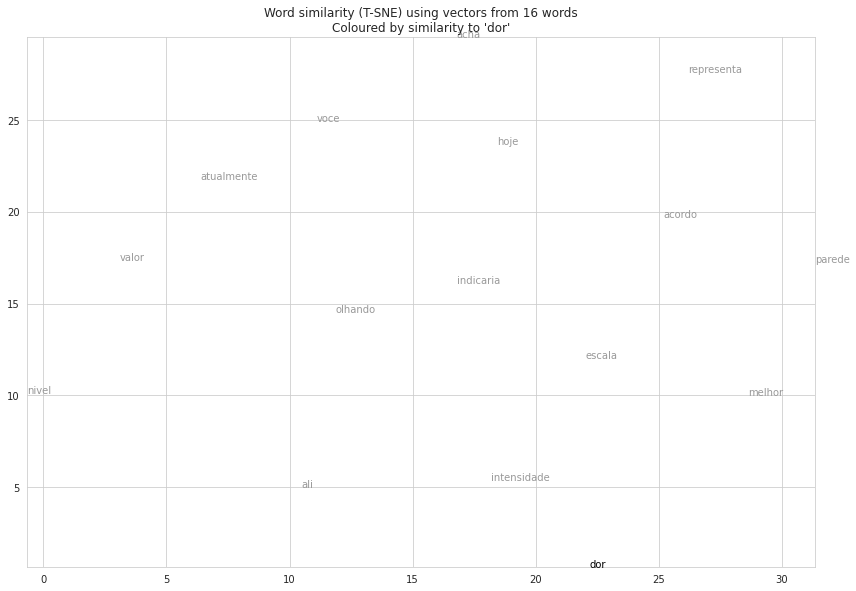

In [31]:
from sklearn.manifold import TSNE

raw_words_of_interest = [x for x in model_wc.wv.vocab]

words_of_interest = []
for woi in raw_words_of_interest:
    for word, _ in model_wc.most_similar(woi):
        words_of_interest.append(word)

words_of_interest = list(set(words_of_interest))

vectors = []
for word in set(words_of_interest):
    vectors.append(model_wc[word])
    
vectors = np.vstack(vectors) # turn vectors into a 2D array <words x 300dim>

model = TSNE(n_components=2, perplexity=10, random_state=0)
X_tsne = model.fit_transform(vectors)
df_after_tsne = pd.DataFrame.from_records(X_tsne, columns=['x', 'y'])
df_after_tsne['labels'] = words_of_interest

# calculate similarity from a target word to all words, to use as our colour
target_word = "dor"
similarities = []
for woi in words_of_interest:
    similarity = min(max(0, model_wc.similarity(target_word, woi)), 1.0)
    similarities.append(similarity)

# plot the T-SNE layout for words, darker words means more similar to our target
plt.figure(figsize=(12,8))
plt.xlim((min(X_tsne[:,0]), max(X_tsne[:,0])))
plt.ylim((min(X_tsne[:,1]), max(X_tsne[:,1])))
for idx in range(X_tsne.shape[0]):
    x, y = X_tsne[idx]
    label = words_of_interest[idx]
    color=str(min(0.6, 1.0-similarities[idx])) # convert to string "0.0".."1.0" as greyscale for mpl
    plt.annotate(s=label, xy=(x, y), color=color)
    #plt.annotate(s=label, xy=(x, y), weight=int(similarities[idx]*1000)) # use weight
plt.tight_layout()
plt.title("Word similarity (T-SNE) using vectors from {} words\nColoured by similarity to '{}'".format(len(words_of_interest), target_word))